In [1]:
import copy
import pickle

import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load temperature data

In [2]:
keep_cols = ["air_temperature", "year", "seq_month", "day", "hour"]
temp_data = pd.read_parquet("temp-freq-e_val.parquet").loc[:, keep_cols]

In [3]:
temp_data

,air_temperature,year,seq_month,day,hour
0,3.9,0,0,1,0
1,4.7,0,0,1,1
2,5.0,0,0,1,2
3,4.8,0,0,1,3
4,4.2,0,0,1,4
...,...,...,...,...,...
534715,12.7,60,731,31,19
534716,12.9,60,731,31,20
534717,12.7,60,731,31,21
534718,12.2,60,731,31,22


# Load result data 

In [5]:
DAM_LOCS = ["L", "R"]
RUN_ID = "2023-01-29T12:51:27.214729_LB_0.02-step-delta"

MODEL = "GH"
RUN_ID = "2023-02-05T19:45:04.032244_GH_0.05-step-delta"
DAM_LOCS = ["L_pier", "R_pier"]

all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S3,S4,S5,speed,x_dam,delta,L_abut,L_pier,R_pier,R_abut
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,10.85,NaN,NaN,23.0,17.733333,0.0,0.000138,0.000066,0.000062,0.000135
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,NaN,NaN,NaN,24.0,17.733333,0.0,0.000257,0.000126,0.000117,0.000246
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,NaN,NaN,NaN,28.0,17.733333,0.0,0.000117,0.000057,0.000055,0.000113
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,NaN,NaN,NaN,27.5,17.733333,0.0,0.000230,0.000096,0.000097,0.000221
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,NaN,NaN,NaN,25.5,17.733333,0.0,0.000120,0.000054,0.000053,0.000108


# Only keep columns we need to speed up computation

In [6]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,L_pier,R_pier
0,0.00,0,0,0,1,1,4,0.000066,0.000062
1,0.00,0,0,0,1,4,3,0.000126,0.000117
2,0.00,0,0,0,1,5,3,0.000057,0.000055
3,0.00,0,0,0,1,5,3,0.000096,0.000097
4,0.00,0,0,0,1,6,2,0.000054,0.000053
...,...,...,...,...,...,...,...,...,...
36701743,0.25,731,60,11,31,22,5,0.000057,0.000054
36701744,0.25,731,60,11,31,22,4,0.000085,0.000081
36701745,0.25,731,60,11,31,22,2,0.000036,0.000034
36701746,0.25,731,60,11,31,23,6,0.000094,0.000089


# Apply high traffic hour sampling

In [7]:
AXLE_DICT = {"All": np.arange(2, 7), "5ax": np.arange(5, 6), "6ax": np.arange(6, 7)}
PROPORTION = 0.125

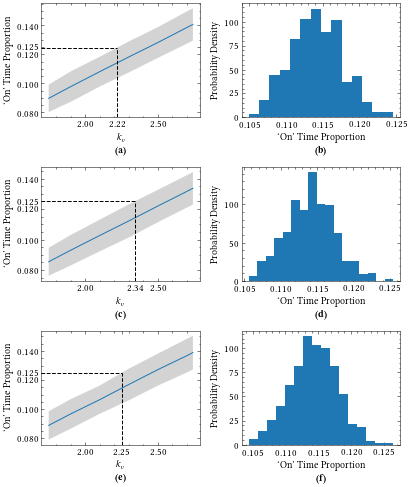

In [8]:
N_reps = 400

# full year baseline
baseline_full = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

# find value of k month by month
month_df = baseline_full.loc[baseline_full.month == 0]

plt.style.use(
    [
        "./ajf_plts/base.mplstyle",
        "./ajf_plts/legend_frame.mplstyle",
        "./ajf_plts/lines_markers.mplstyle",
    ]
)

figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3, ncols=2)

traffic_pmf = {}
opt_kv = {}
for i, (k, v) in enumerate(AXLE_DICT.items()):
    # extract traffic profile from baseline full year
    traffic_pmf[k] = (
        baseline_full.loc[baseline_full.AxleCount.isin(v)]
        .groupby("hour")
        .agg("count")
        .iloc[:, 0]
    )
    traffic_pmf[k] /= traffic_pmf[k].sum()

    kvs = np.arange(1.5, 3.6, 0.2)
    on_props = []
    for kv in kvs:
        on_props.append(
            [
                (
                    np.random.uniform(size=len(month_df.hour))
                    < (kv * traffic_pmf[k].loc[month_df.hour])
                ).sum()
                / len(month_df.hour)
                for _ in range(N_reps)
            ]
        )

    means = np.mean(on_props, axis=1)
    stds = np.std(on_props, axis=1)

    kv_int = np.arange(1.75, 2.75, 0.01)
    int_means = np.interp(kv_int, kvs, means)
    int_stds = np.interp(kv_int, kvs, stds)

    axes[i, 0].plot(kv_int, int_means, marker="")
    axes[i, 0].fill_between(
        kv_int,
        int_means - 3.0 * int_stds,
        int_means + 3.0 * int_stds,
        fc="lightgrey",
        zorder=-100,
    )

    opt_ind = np.abs(int_means + 3.0 * int_stds - PROPORTION).argmin()
    opt_kv[k] = kv_int[opt_ind]
    opt_mean = int_means[opt_ind] + 3.0 * int_stds[opt_ind]

    xlims = axes[i, 0].get_xlim()
    xlim_range = xlims[1] - xlims[0]

    ylims = axes[i, 0].get_ylim()
    ylim_range = ylims[1] - ylims[0]

    axes[i, 0].set_xticks(list(axes[i, 0].get_xticks()) + [opt_kv[k]])
    axes[i, 0].set_yticks(list(axes[i, 0].get_yticks()) + [PROPORTION])

    axes[i, 0].axhline(
        y=opt_mean,
        xmin=0,
        xmax=(opt_kv[k] - xlims[0]) / xlim_range,
        ls="--",
        color="k",
    )
    axes[i, 0].axvline(
        x=opt_kv[k],
        ymin=0,
        ymax=(opt_mean - ylims[0]) / ylim_range,
        ls="--",
        color="k",
    )
    axes[i, 0].set_xlim(xlims)
    axes[i, 0].set_ylim(ylims)

    axes[i, 0].set_xlabel("$k_v$")
    axes[i, 0].set_ylabel("`On' Time Proportion")

    opt_props = [
        (
            np.random.uniform(size=len(month_df.hour))
            < (opt_kv[k] * traffic_pmf[k].loc[month_df.hour])
        ).sum()
        / len(month_df.hour)
        for _ in range(N_reps)
    ]
    axes[i, 1].hist(opt_props, bins=ajf_utils.get_FD_n_bins(opt_props), density=True)

    axes[i, 1].set_xlabel("`On' Time Proportion")
    axes[i, 1].set_ylabel("Probability Density")

ajf_plts.caption_axes(axes.ravel())
fig.tight_layout()

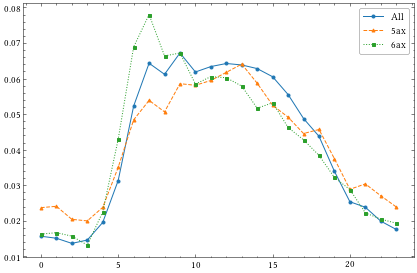

In [9]:
fig, ax = plt.subplots()

for k, v in AXLE_DICT.items():
    ax.plot(traffic_pmf[k], label=k)
ax.legend()
fig.tight_layout()

In [10]:
def calc_on_prop(k, data):
    on_props = np.array(
        [
            np.random.uniform(size=len(data)) < k * temp_dist.pdf(data)
            for _ in range(2000)
        ]
    )
    return np.median(on_props.sum(axis=1) / len(data))


def loss(k, data):
    return np.abs(calc_on_prop(k, data) - PROPORTION)


def get_samp_tups(df):
    desired_N = int(PROPORTION * len(df))
    k_probs = opt_kv[k] * traffic_pmf[k].loc[df.hour]
    mask = np.array(len(df) * [False])
    while mask.sum() < desired_N:
        mask += np.random.uniform(size=len(df)) < k_probs
    samp_times = df[mask.values].loc[:, ["seq_month", "day", "hour"]]
    return samp_times.apply(tuple, axis=1).sample(n=desired_N)


samp_tups = {}
samp_data = {}
for k, v in AXLE_DICT.items():
    df = res_data.loc[res_data.AxleCount.isin(v)].set_index(
        ["seq_month", "day", "hour"]
    )
    samp_tups[k] = temp_data.groupby(["seq_month"]).parallel_apply(get_samp_tups)
    samp_data[k] = df.loc[df.index.isin(samp_tups[k])]

In [11]:
# samp_data = {}
# for k, v in AXLE_DICT.items():
#     df = res_data.loc[res_data.AxleCount.isin(v)].set_index(
#         ["seq_month", "day", "hour"]
#     )
#     monthly_hours = pd.MultiIndex.from_product(df.index.levels[1:])
#
#     months = df.index.levels[0]
#     vals = []
#     for m in months:
#         mask = np.random.uniform(size=len(monthly_hours)) < (
#             opt_kv[k] * traffic_pmf[k].loc[monthly_hours.get_level_values(-1)]
#         )
#         sample_hours = monthly_hours.to_frame()[mask.values]
#         sample_hours["seq_month"] = m
#         vals.append(sample_hours)
#
#     sample_hours = (
#         pd.concat(vals).reset_index(drop=True).sort_values(["seq_month", "day", "hour"])
#     )
#
#     sample_idx = pd.MultiIndex.from_frame(sample_hours).reorder_levels([2, 0, 1])
#
#     mask = df.index.isin(sample_idx)
#
#     samp_data[k] = df.loc[mask]

In [12]:
def calc_emd(df):
    return dict(
        zip(
            [l + "_" + k for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baselines[k].loc[:, l].values,
                    df.loc[:, l].values,
                )
                for l in DAM_LOCS
            ],
        )
    )


baselines = {}
emd_vals = []
for k, v in AXLE_DICT.items():
    baselines[k] = samp_data[k].loc[
        (samp_data[k].delta == 0.0) & samp_data[k].AxleCount.isin(v)
    ]
    emd_vals.append(samp_data[k].groupby(["delta", "year"]).parallel_apply(calc_emd))

In [13]:
emd_samp_df = pd.concat([pd.json_normalize(e) for e in emd_vals], axis=1)
emd_samp_df.index = emd_vals[0].index
emd_samp_df *= 1e6

In [14]:
# sample sizes

In [15]:
for k, v in AXLE_DICT.items():
    count_stats = (
        samp_data[k]
        .groupby(["delta", "year"])
        .agg("count")
        .agg(["mean", "median", "std"])
        .iloc[:, 0]
    )
    print(
        k,
        f"\\num{{{count_stats.loc['mean']:.0f}}}\,(\\num{{{count_stats.loc['std']:.1f}}})",
    )

All \num{15370}\,(\num{272.1})
5ax \num{4797}\,(\num{129.4})
6ax \num{1927}\,(\num{60.7})


# On Time

In [16]:
prop_on = {}
for k, v in AXLE_DICT.items():
    N_on = samp_tups[k].groupby("seq_month").apply(lambda g: len(g.index.unique()))
    N_all = temp_data.groupby("seq_month").apply(lambda g: len(g.index.unique()))
    prop_on[k] = N_on / N_all
    print(k, np.mean(prop_on[k]), np.std(prop_on[k]))

All 0.125 0.0
5ax 0.125 0.0
6ax 0.125 0.0


In [17]:
# Needed for stuff later on

# Plot Graphs

## Prediction interval plots

In [18]:
from importlib import reload

ajf_utils = reload(ajf_utils)

### Sampled baseline

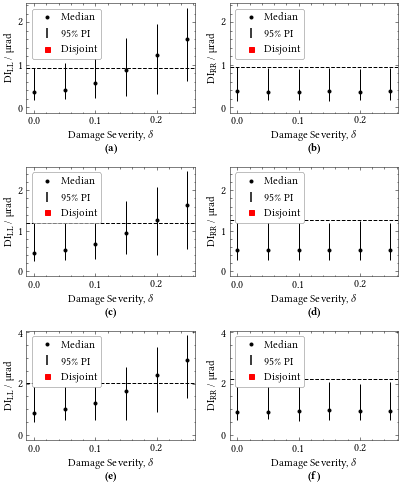

In [19]:
fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
ajf_plts.save_fig(fig, "figTrafficVolumePIPlotsSamp.pdf")

# Table of stats tests

### Sampled baseline

In [22]:
tab = ajf_utils.format_pred_int_table(emd_samp_df, DAM_LOCS)
with open("./output/tabTrafficVolumePIsSamp.tex", "w") as f:
    f.write(tab)
print(tab)

\begin{tabular}{lcccccc}

    \toprule
    {    } & \multicolumn{3}{c}{$\DI{LL}$ (\unit{\micro\radian})} & \multicolumn{3}{c}{$\DI{RR}$ (\unit{\micro\radian})}\\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7}
    $\delta$ & All &  5-axle & 6-axle &  All & 5-axle &  6-axle\\
    \midrule
    0.00 & (0.32, 1.53) & (0.423, 1.99) & (0.631, 2.69) & (0.309, 1.53) & (0.409, 2.09) & (0.775, 2.53)\\
0.02 & (0.281, 1.97) & (0.517, 2.71) & (0.757, 3.61) & (0.288, 1.47) & (0.416, 2.02) & (0.807, 2.88)\\
0.04 & (0.665, 3.02) & (0.831, 3.79) & (1.83, 5.72) & (0.28, 1.87) & (0.515, 2.65) & (0.751, 3.49)\\
0.06 & (1.42, 4.06) & (1.81, 5.05) & \bfseries(3.74, 7.7) & (0.435, 2.32) & (0.615, 3.1) & (1.08, 4.57)\\
0.08 & \bfseries(2.44, 5.12) & \bfseries(3.02, 6.48) & \bfseries(5.64, 9.69) & (0.572, 2.8) & (0.813, 3.65) & (1.57, 5.5)\\
0.10 & \bfseries(3.58, 6.27) & \bfseries(4.43, 7.78) & \bfseries(7.72, 11.9) & (0.777, 3.27) & (1.08, 4.28) & (2.28, 6.49)\\
0.12 & \bfseries(4.73, 7.46) & \bfseries(5.73, 9.24)